# **Forest Fire Model from Drossel and Schwabl (1992)**

In [ ]:
""" Drossel-Schwabl Forest Fire Model — Fully Featured 🔥 """

import matplotlib.pyplot as plt
import numpy as np
from numpy import uint8
from IPython.display import clear_output
plt.rcParams.update({'font.size': 14})
from numba import njit


@njit
def update(
    landscape, tree_growth_rate, lightning_strike_rate, update_plot_wait,
    tree_percent_record
):
    Lx, Ly = landscape.shape
    p = tree_growth_rate / (Lx * Ly)
    f = lightning_strike_rate / (Lx * Ly)

    tree_site = uint8(0)
    empty_site = uint8(1)
    burning_site = uint8(2)

    for _ in range(update_plot_wait):
        new_burning_sites = []
        new_empty_sites = []
        new_tree_sites = []
        num_trees = 0
        neighbors = np.full((4, 2), 0)

        for i in range(Lx):
            for j in range(Ly):
                site_status = landscape[i, j]
                if site_status == burning_site:
                    neighbors[:] = np.array([[i-1, j], [i+1, j], [i, j-1], [i, j+1]])
                    for ni, nj in neighbors:
                        if 0 <= ni < Lx and 0 <= nj < Ly:
                            if landscape[ni, nj] == tree_site:
                                new_burning_sites.append([ni, nj])
                                num_trees -= 1
                    new_empty_sites.append([i, j])
                elif site_status == tree_site:
                    if np.random.random() < f:
                        new_burning_sites.append([i, j])
                    else:
                        num_trees += 1
                else:
                    if np.random.random() < p:
                        new_tree_sites.append([i, j])
                        num_trees += 1

        for i, j in new_empty_sites:
            landscape[i, j] = empty_site
        for i, j in new_burning_sites:
            landscape[i, j] = burning_site
        for i, j in new_tree_sites:
            landscape[i, j] = tree_site

        tree_percent = num_trees * 100 / (Lx * Ly)
        tree_percent_record = np.append(tree_percent_record, tree_percent)

    return tree_percent_record


def landscape_to_colors(landscape):
    Lx, Ly = landscape.shape
    color_matrix = np.empty((Lx, Ly, 3))
    tree_site, empty_site, burning_site = (uint8(i) for i in range(3))
    color_matrix[landscape == empty_site] = [0., 0., 0.]    # empty → black
    color_matrix[landscape == burning_site] = [1., 0., 0.]  # burning → red
    color_matrix[landscape == tree_site] = [0., 1., 0.]     # tree → green
    return color_matrix


def setup_plot():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.tight_layout(pad=2.0)
    ax1.axis('off')
    ax1.set_title('Forest Landscape')
    ax2.set_xlabel('time')
    ax2.set_ylabel('% trees')
    ax2.set_ylim(0, 100)
    return fig, ax1, ax2


def update_plot(landscape, tree_percent, t, pause_time=0.001):
    fig, ax1, ax2 = setup_plot()
    ax1.imshow(landscape_to_colors(landscape))
    ax2.plot(np.arange(len(tree_percent)), tree_percent, c='blue')
    avg_tree_pct = round(np.mean(tree_percent))
    ax2.set_title('Average tree coverage: ' + str(avg_tree_pct) + '%')
    clear_output(wait=True)
    fig.canvas.draw()
    plt.pause(pause_time)


def has_tree_fraction_stabilized(tree_percent_record, window=100, threshold=0.01):
    if len(tree_percent_record) < window:
        return False
    recent = tree_percent_record[-window:]
    return np.max(recent) - np.min(recent) < threshold


def ignite_patch(landscape, cx, cy, fire_radius, fire_shape, tree_site, burning_site):
    Lx, Ly = landscape.shape
    for i in range(cx - fire_radius, cx + fire_radius + 1):
        for j in range(cy - fire_radius, cy + fire_radius + 1):
            if 0 <= i < Lx and 0 <= j < Ly:
                if landscape[i, j] == tree_site:
                    if fire_shape == "circle":
                        if (i - cx)**2 + (j - cy)**2 <= fire_radius**2:
                            landscape[i, j] = burning_site
                    else:
                        landscape[i, j] = burning_site


def run_simulation(
    Lx=100,
    Ly=100,
    start_tree_percent=50,
    start_fire=1,
    fire_location=None,
    fire_shape="square",
    fire_radius=3,
    num_random_fires=0,
    tree_growth_rate=1000,
    lightning_strike_rate=2,
    update_plot_wait=1,
    max_steps=100000,
    stabilize_check_window=100,
    stabilize_threshold=0.01
):
    tree_fraction = start_tree_percent / 100.
    tree_site, empty_site, burning_site = (uint8(i) for i in range(3))
    landscape = np.random.choice(
        [tree_site, empty_site], p=[tree_fraction, 1 - tree_fraction], size=(Lx, Ly)
    )

    # 🔥 Fire logic
    if start_fire == 0:
        landscape[:, 0] = burning_site
    elif start_fire == 1 or fire_location or num_random_fires > 0:
        # Central or custom fire
        if fire_location:
            fire_centers = [fire_location]
        else:
            center_x, center_y = Lx // 2, Ly // 2
            fire_centers = [(center_x, center_y)]

        # Add random fire centers
        for _ in range(num_random_fires):
            rand_x = np.random.randint(fire_radius, Lx - fire_radius)
            rand_y = np.random.randint(fire_radius, Ly - fire_radius)
            fire_centers.append((rand_x, rand_y))

        # Ignite patches
        for cx, cy in fire_centers:
            ignite_patch(landscape, cx, cy, fire_radius, fire_shape, tree_site, burning_site)

    # Initialize
    time = 0
    tree_percent = 100 * np.sum(landscape == 0) / (Lx * Ly)
    tree_percent_record = np.array([tree_percent])
    fire_sizes = []
    fire_durations = []
    fire_active = False
    current_fire_size = 0
    current_fire_duration = 0

    for step in range(0, max_steps, update_plot_wait):
        update_plot(landscape, tree_percent_record, time)

        current_burning = np.sum(landscape == burning_site)
        if current_burning > 0:
            if not fire_active:
                fire_active = True
                current_fire_size = 0
                current_fire_duration = 0
            current_fire_size += current_burning
            current_fire_duration += 1
        elif fire_active:
            fire_sizes.append(current_fire_size)
            fire_durations.append(current_fire_duration)
            fire_active = False

        tree_percent_record = update(
            landscape,
            tree_growth_rate,
            lightning_strike_rate,
            update_plot_wait,
            tree_percent_record
        )
        time += update_plot_wait

        if has_tree_fraction_stabilized(tree_percent_record, stabilize_check_window, stabilize_threshold):
            print(f"\n✅ Tree fraction stabilized — stopping early at step {step}.")
            break

    print("\n🔥 Simulation Complete")
    print(f"Total Fires: {len(fire_sizes)}")
    if fire_sizes:
        print(f"Average Fire Size: {np.mean(fire_sizes):.2f}")
        print(f"Average Fire Duration: {np.mean(fire_durations):.2f}")

    return tree_percent_record, fire_sizes, fire_durations

# **Run and Visualize the Fire**

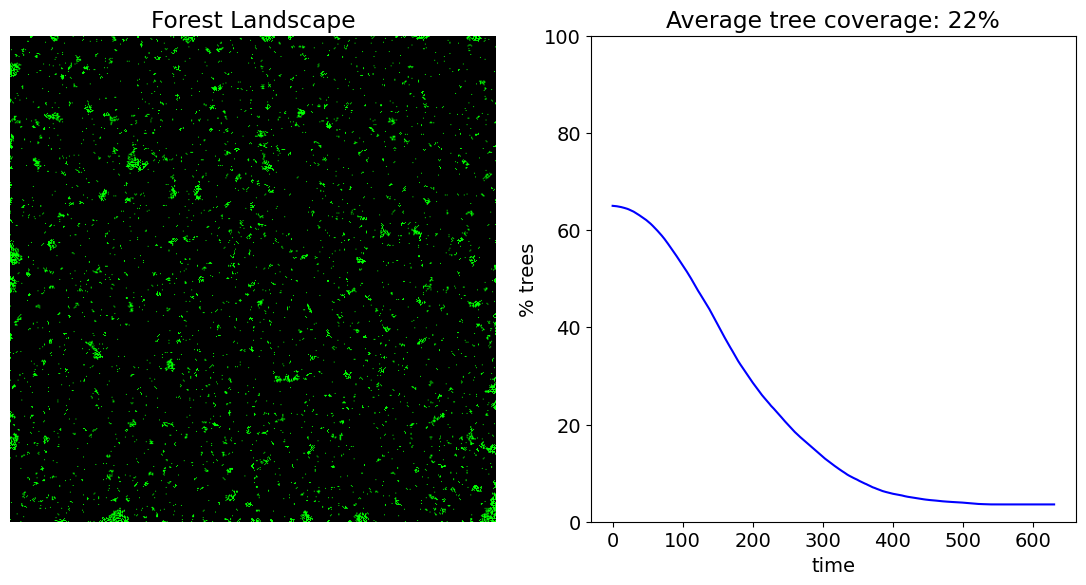


✅ Tree fraction stabilized — stopping early at step 630.

🔥 Simulation Complete
Total Fires: 1
Average Fire Size: 16064.00
Average Fire Duration: 55.00


<ipython-input-3-4dd1ab669528>:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


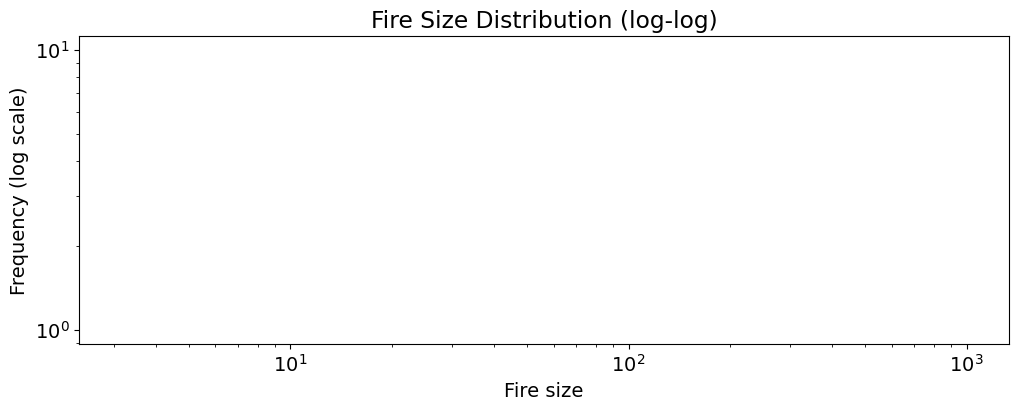

In [ ]:
# Run the model
tree_record, fire_sizes, fire_durations = run_simulation(
    Lx=512,                    # number of sites in x direction
    Ly=512,                    # number of sites in y direction
    start_tree_percent=65,     # initial percentage of sites with trees
    start_fire=1,              # 0 = left edge, 1 = center
    fire_location=None,         # where does the fire start?
    fire_shape="circle",       # fire shape: "circle" or "square"
    fire_radius=1,             # radius of initial fire
    num_random_fires=5,        # number of random fires to add
    tree_growth_rate=0,        # number of trees growing per timestep
    lightning_strike_rate=0,   # number of lightning strikes per timestep
    update_plot_wait=10,       # update plot every this many timesteps
    max_steps=100000           # max steps before stopping
)

# # Plot fire size histogram
# plt.figure(figsize=(12, 4))
# plt.hist(fire_sizes, bins=100, color='firebrick', edgecolor='firebrick')
# plt.xlabel("Fire size (burning trees per event)")
# plt.ylabel("Frequency")
# plt.title("Fire Size Distribution")
# plt.show()
plt.figure(figsize=(12, 4))
plt.hist(fire_sizes, bins=np.logspace(0.5, 3, 10), log=True, color='darkorange', edgecolor='black')
plt.xscale('log')
plt.xlabel("Fire size")
plt.ylabel("Frequency (log scale)")
plt.title("Fire Size Distribution (log-log)")
plt.show()


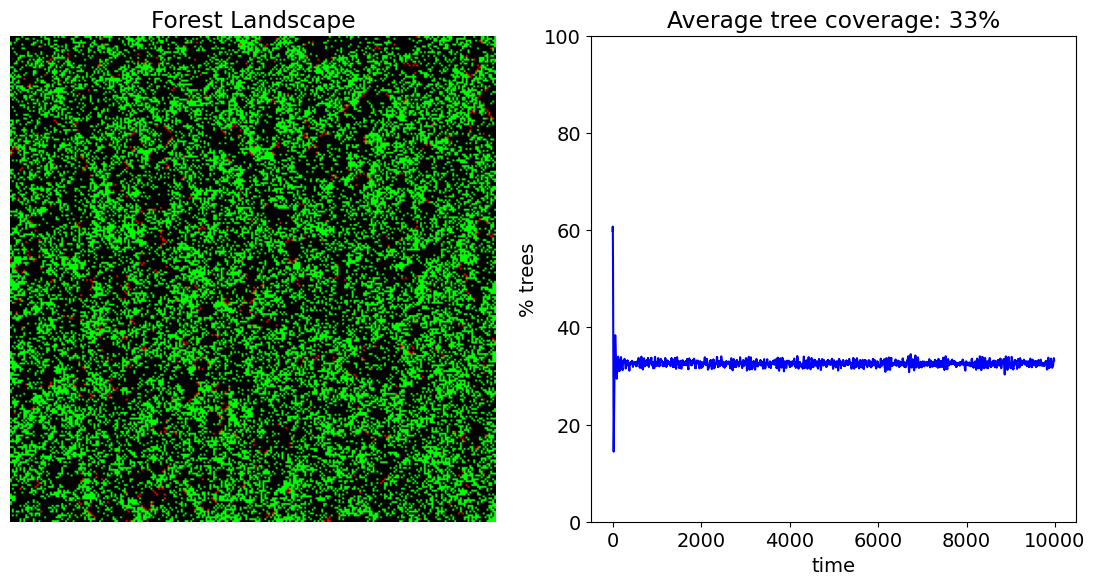


🔥 Simulation Complete
Total Fires: 0


In [ ]:
ratios = np.logspace(-4, -1, 10)  # test different f/p ratios
critical_data = []

for r in ratios:
    p = 1000
    f = int(p * r)
    print(f"Testing p={p}, f={f} (ratio={r:.1e})")

    _, fire_sizes, _ = run_simulation(
        Lx=256, Ly=256,
        start_tree_percent=60,
        tree_growth_rate=p,
        lightning_strike_rate=f,
        update_plot_wait=20,
        max_steps=10000,
        fire_radius=1,
        fire_shape="circle",
        num_random_fires=0,
        start_fire=1,
        stabilize_check_window=200,
        stabilize_threshold=0.1
    )
    critical_data.append((r, fire_sizes))


In [ ]:
from scipy.stats import linregress
import numpy as np

def estimate_power_law_exponent(fire_sizes, min_size=1):
    sizes = np.array(fire_sizes)
    sizes = sizes[sizes >= min_size]  # ignore very small fires

    if len(sizes) == 0:
        print("⚠️ No fire sizes above the threshold to analyze.")
        return None, None

    max_size = sizes.max()
    if max_size <= min_size:
        print("⚠️ All fire sizes are too small.")
        return None, None

    hist, bin_edges = np.histogram(
        sizes,
        bins=np.logspace(np.log10(min_size), np.log10(max_size), 30)
    )
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    log_x = np.log10(bin_centers[hist > 0])
    log_y = np.log10(hist[hist > 0])

    if len(log_x) < 2:
        print("⚠️ Not enough data points for reliable regression.")
        return None, None

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    return -slope, r_value**2

In [ ]:
exponent, r2 = estimate_power_law_exponent(fire_sizes)

if exponent is not None:
    print(f"Estimated power-law exponent: {exponent:.2f}, R²: {r2:.3f}")
else:
    print("⚠️ Could not estimate power-law exponent (insufficient fire data).")


⚠️ No fire sizes above the threshold to analyze.
⚠️ Could not estimate power-law exponent (insufficient fire data).


In [ ]:
print(f"Number of fires: {len(fire_sizes)}")
if fire_sizes:
    print(f"Min fire size: {min(fire_sizes)}, Max fire size: {max(fire_sizes)}")


Number of fires: 0


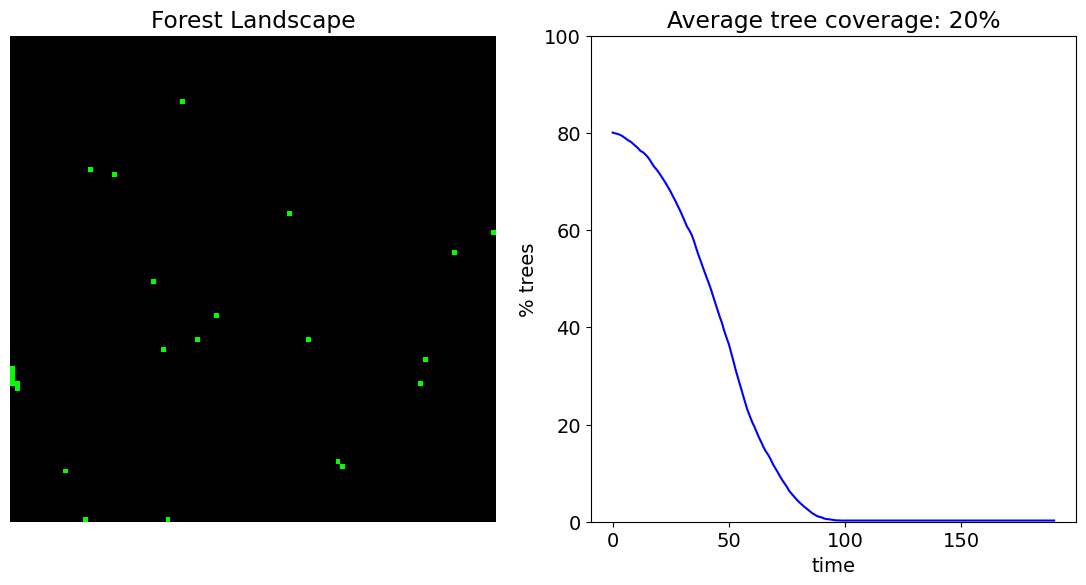


✅ Tree fraction stabilized — stopping early at step 190.

🔥 Simulation Complete
Total Fires: 1
Average Fire Size: 784.00
Average Fire Duration: 10.00


In [ ]:
tree_record, fire_sizes, fire_durations = run_simulation(
    Lx=100,
    Ly=100,
    start_tree_percent=80,
    tree_growth_rate=0,          # regrowth enabled
    lightning_strike_rate=0,        # some random fires
    update_plot_wait=10,
    max_steps=1000,
    fire_radius=3,
    fire_shape="circle",
    start_fire=1,
    num_random_fires=0
)

In [ ]:
exponent, r2 = estimate_power_law_exponent(fire_sizes, min_size=10)

if exponent is not None:
    print(f"Estimated power-law exponent: {exponent:.2f}, R²: {r2:.3f}")
else:
    print("⚠️ Could not estimate power-law exponent (insufficient fire data).")


⚠️ Not enough data points for reliable regression.
⚠️ Could not estimate power-law exponent (insufficient fire data).
